In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

## Nonlinear AutoRegression

### Example One

We fit the NonLinear AR(1) model to a simulated dataset generated using the following equation: 
\begin{equation*}
   y_t = \frac{2 y_{t-1}}{1 + 0.8 y_{t-1}^2} + \epsilon_t
\end{equation*}
where $\epsilon_t \overset{\text{i.i.d}}{\sim} \text{uniform}(-1, 1)$. 

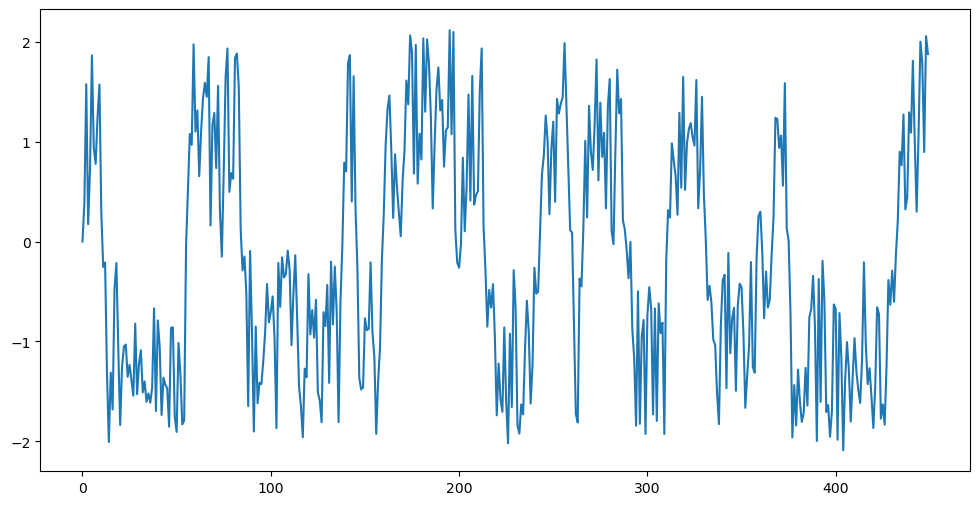

In [3]:
n = 450
rng = np.random.default_rng(seed = 40)
eps = rng.uniform(low = -1.0, high = 1.0, size = n) 

y_sim = np.full(n, 0, dtype = float) 
for i in range(1, n):
    y_sim[i] = ((2*y_sim[i-1])/(1 + 0.8 * (y_sim[i-1] ** 2))) + eps[i]

plt.figure(figsize = (12, 6))
plt.plot(y_sim)
plt.show()

This dataset is generated as $y_t = g(y_{t-1}) + \epsilon_t$ where $g(x) := 2x/(1 + 0.8 x^2)$. The function $g$ is plotted below. 

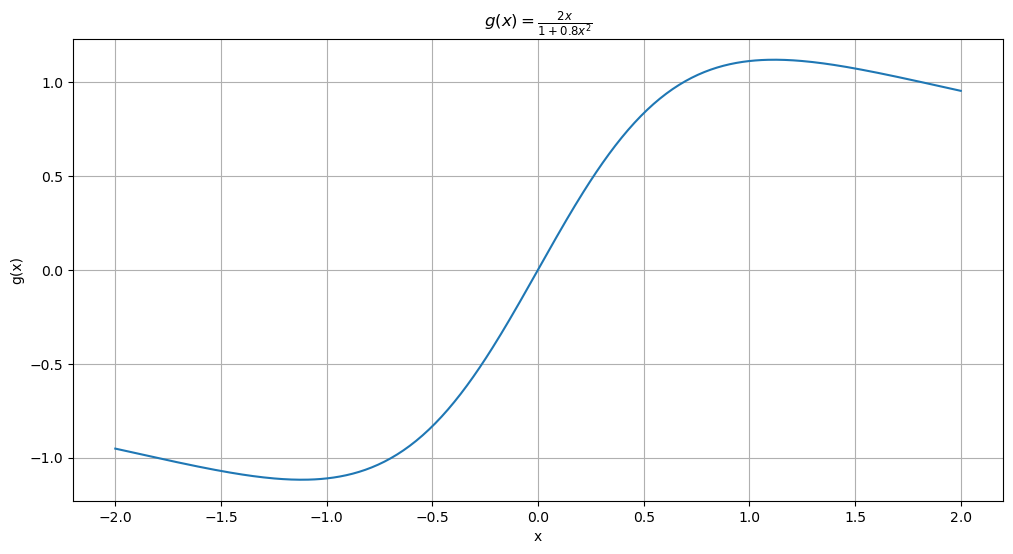

In [4]:
def g(x):
    return 2 * x / (1 + 0.8 * x**2)

x_vals = np.linspace(-2, 2, 400)
y_vals = g(x_vals)

# Plot the function
plt.figure(figsize = (12, 6))
plt.plot(x_vals, y_vals)
plt.title(r'$g(x) = \frac{2x}{1 + 0.8x^2}$')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.grid(True)
plt.show()

We will fit the model (below $x_t = y_{t-1}$)
\begin{equation*}
  \mu_t = \beta_0 + \beta_1 x_t + \beta_2 (x_t - c_1)_+ + \dots +
  \beta_{k+1} (x_t - c_k)_+. 
\end{equation*}
This model is represented by the following class. 


In [5]:
class PiecewiseLinearModel(nn.Module):
    def __init__(self, knots_init, beta_init):
        super().__init__()
        self.num_knots = len(knots_init)
        self.beta = nn.Parameter(torch.tensor(beta_init, dtype=torch.float32)) 
        self.knots = nn.Parameter(torch.tensor(knots_init, dtype=torch.float32))

    def forward(self, x):
        knots_sorted, _ = torch.sort(self.knots)
        out = self.beta[0] + self.beta[1] * x
        for j in range(self.num_knots):
            out += self.beta[j + 2] * torch.relu(x - knots_sorted[j])
        return out

We create tensors for $x$ and $y$ below. 

In [6]:
y_reg = y_sim[1:]
x_reg = y_sim[0:(n-1)]

y_torch = torch.tensor(y_reg, dtype = torch.float32).unsqueeze(1)
x_torch = torch.tensor(x_reg, dtype = torch.float32).unsqueeze(1)

Below we find initial values for $c_1, \dots, c_k$ and $\beta_0, \beta_1, \dots, \beta_{k+1}$. 

In [7]:
k = 6
quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
knots_init = np.quantile(x_reg, quantile_levels)

n_reg = len(y_reg)
X = np.column_stack([np.ones(n_reg), x_reg])
for j in range(k):
    xc = ((x_reg > knots_init[j]).astype(float))*(x_reg - knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(y_reg, X).fit()
beta_init = md_init.params
print(knots_init)
print(beta_init)

[-1.54280223 -1.02805822 -0.60360061 -0.09440788  0.61283012  1.2719812 ]
[-2.31279716 -0.66056549  0.83205759  0.42017211  0.77300214  0.83540066
 -2.59891684  0.37725608]


Below we fit the model and estimate parameters. 

In [9]:
nar = PiecewiseLinearModel(knots_init = knots_init, beta_init = beta_init)

In [10]:
optimizer = optim.Adam(nar.parameters(), lr = 0.01)
loss_fn = nn.MSELoss()

for epoch in range(10000): 
    optimizer.zero_grad()
    y_pred = nar(x_torch)
    loss = loss_fn(y_pred, y_torch)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
#Run this code a few times to be sure of convergence. 

Epoch 0, Loss: 0.3186
Epoch 100, Loss: 0.3166
Epoch 200, Loss: 0.3163
Epoch 300, Loss: 0.3162
Epoch 400, Loss: 0.3161
Epoch 500, Loss: 0.3161
Epoch 600, Loss: 0.3161
Epoch 700, Loss: 0.3161
Epoch 800, Loss: 0.3161
Epoch 900, Loss: 0.3161
Epoch 1000, Loss: 0.3161
Epoch 1100, Loss: 0.3161
Epoch 1200, Loss: 0.3161
Epoch 1300, Loss: 0.3161
Epoch 1400, Loss: 0.3161
Epoch 1500, Loss: 0.3161
Epoch 1600, Loss: 0.3161
Epoch 1700, Loss: 0.3161
Epoch 1800, Loss: 0.3161
Epoch 1900, Loss: 0.3161
Epoch 2000, Loss: 0.3161
Epoch 2100, Loss: 0.3161
Epoch 2200, Loss: 0.3161
Epoch 2300, Loss: 0.3161
Epoch 2400, Loss: 0.3161
Epoch 2500, Loss: 0.3161
Epoch 2600, Loss: 0.3161
Epoch 2700, Loss: 0.3161
Epoch 2800, Loss: 0.3161
Epoch 2900, Loss: 0.3161
Epoch 3000, Loss: 0.3161
Epoch 3100, Loss: 0.3161
Epoch 3200, Loss: 0.3161
Epoch 3300, Loss: 0.3161
Epoch 3400, Loss: 0.3161
Epoch 3500, Loss: 0.3161
Epoch 3600, Loss: 0.3161
Epoch 3700, Loss: 0.3161
Epoch 3800, Loss: 0.3161
Epoch 3900, Loss: 0.3161
Epoch 4000, 

Below we plot the function $g$ and the estimated function $\hat{g}$. 

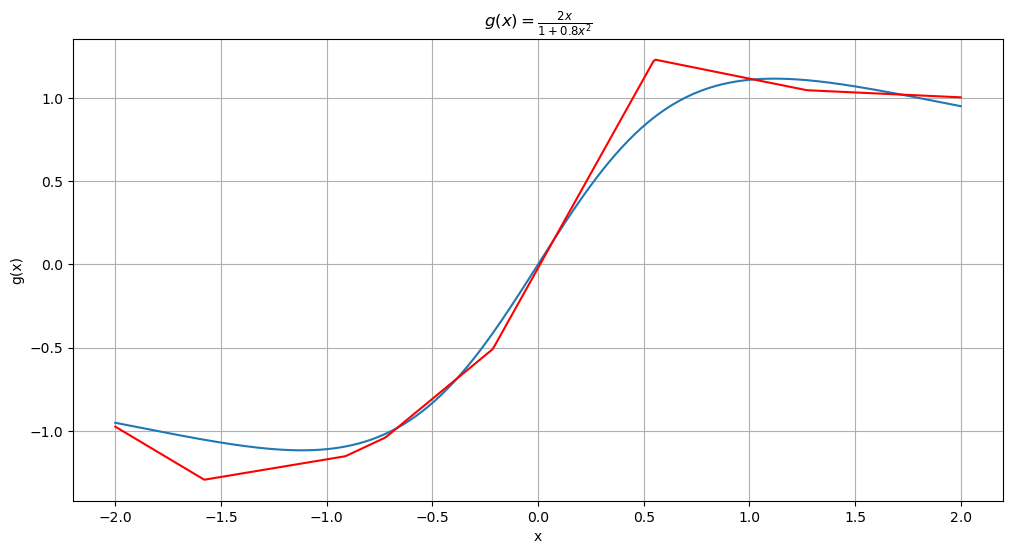

In [11]:
x_vals_torch = torch.tensor(x_vals, dtype = torch.float32).unsqueeze(1)
ghat_nar = nar(x_vals_torch).detach().numpy()

# Plot the function
plt.figure(figsize = (12, 6))
plt.plot(x_vals, y_vals, label = 'True function g')
plt.plot(x_vals, ghat_nar, color = 'red', label = 'Fitted function by the Nonlinear AR model')
plt.title(r'$g(x) = \frac{2x}{1 + 0.8x^2}$')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.grid(True)
plt.show()

We can also superimpose the fitted linear function by the usual AR(1) model. 

[-0.03280141  0.81247368]


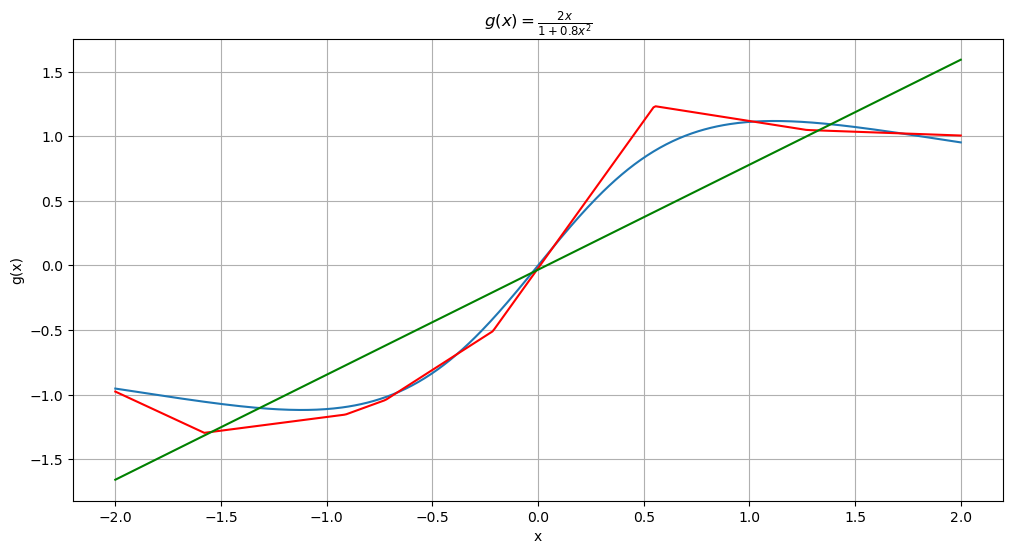

In [12]:
#Function fitted by AR(1)
ar = AutoReg(y_sim, lags = 1).fit() 
print(ar.params)
ar_vals = ar.params[0] + ar.params[1] * x_vals

# Plot the function
plt.figure(figsize = (12, 6))
plt.plot(x_vals, y_vals, label = 'True function g')
plt.plot(x_vals, ghat_nar, color = 'red', label = 'Fitted function by the Nonlinear AR model')
plt.plot(x_vals, ar_vals, color = 'green', label = 'Fitted function by the AR(1) model')
plt.title(r'$g(x) = \frac{2x}{1 + 0.8x^2}$')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.grid(True)
plt.show()

We plot these fitted functions on the data $(y_{t-1}, y_t)$. 

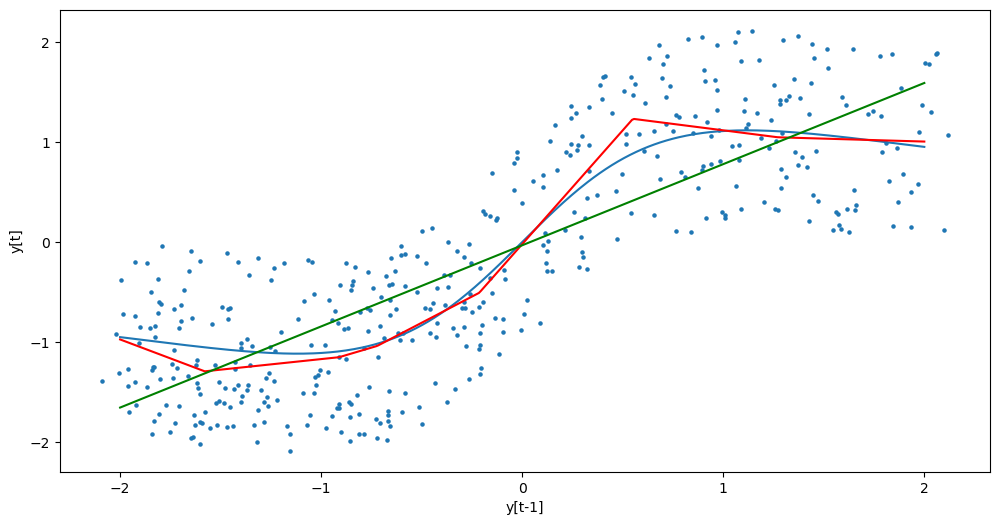

In [13]:
plt.figure(figsize = (12, 6))
plt.scatter(y_sim[:-1], y_sim[1:], s = 5)
plt.plot(x_vals, y_vals, label = 'True function g')
plt.plot(x_vals, ghat_nar, color = 'red', label = 'Fitted function by the Nonlinear AR model')
plt.plot(x_vals, ar_vals, color = 'green', label = 'Fitted function by the AR(1) model')
plt.xlabel('y[t-1]')
plt.ylabel('y[t]')
plt.show()

Now we obtain predictions for future observations. We obtain predictions with the fitted nonlinear AR(1) model as well as the model where we use the true $g$ function. 

In [14]:
#Predictions: 
#with fitted model
last_val = torch.tensor([[y_sim[-1]]], dtype = torch.float32)
future_preds = []
k_future = 100
for _ in range(k_future):
    next_val = nar(last_val)
    future_preds.append(next_val.item())
    last_val = next_val.detach()
future_preds_array = np.array(future_preds)

#with actual g
actual_preds = []
for _ in range(k_future):
    next_val = ((2*last_val)/(1 + 0.8 * (last_val ** 2)))
    actual_preds.append(next_val.item())
    last_val = next_val.detach()
actual_preds_array = np.array(actual_preds)


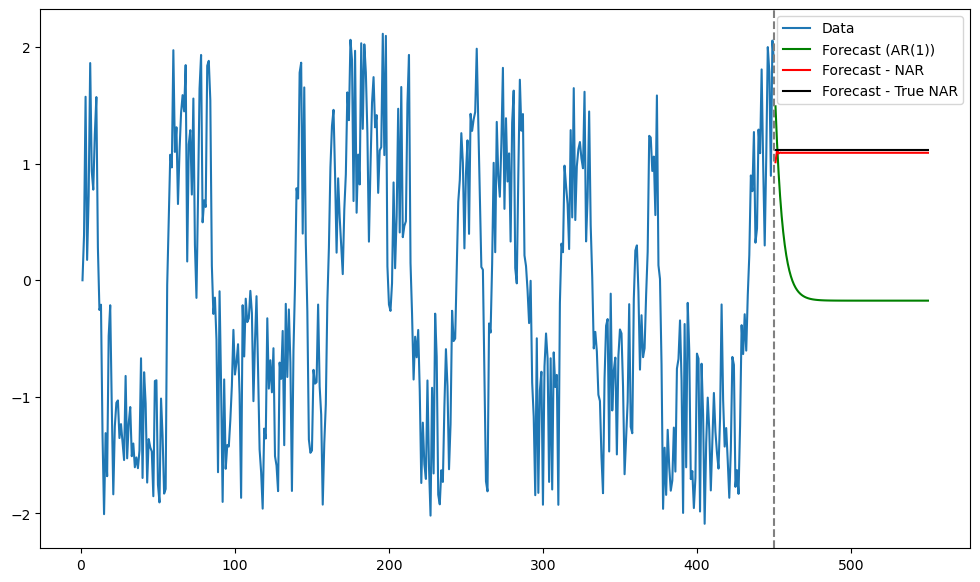

In [15]:
n_y = len(y_sim)
tme = range(1, n_y+1)
tme_future = range(n_y+1, n_y+k_future+1)
fcast = ar.get_prediction(start = n_y, end = n_y+k_future-1).predicted_mean
plt.figure(figsize = (12, 7))
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, fcast, label = 'Forecast (AR(1))', color = 'green')
plt.plot(tme_future, future_preds_array, label = 'Forecast - NAR', color = 'red')
plt.plot(tme_future, actual_preds_array, label = 'Forecast - True NAR', color = 'black')
plt.axvline(x=n_y, color='gray', linestyle='--')
plt.legend()
plt.show()

It is clear that the predictions obtained by the NAR(1) model are very close to those obtained by using the true $g$ function. Also these predictions are quite different from the predictions of the linear AR(1) model. 

## Example Two

Below we change the data generation model to: 
\begin{equation*}
   y_t = \frac{2 y_{t-5}}{1 + 0.8 y_{t-5}^2} + \epsilon_t. 
\end{equation*}
In other words, $y_{t-1}$ is replaced by $y_{t-5}$.  

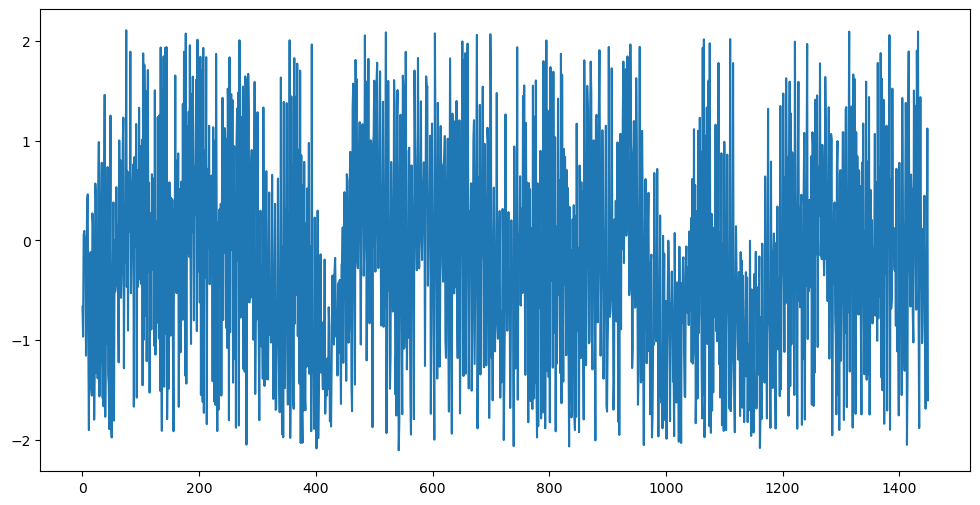

In [16]:
n = 1450
rng = np.random.default_rng(seed = 40)
eps = rng.uniform(low = -1.0, high = 1.0, size = n) 

truelag = 5
y_sim = np.full(n, 0, dtype = float) 
y_sim[:(truelag - 1)] = rng.uniform(low = -1, high = 1, size = truelag - 1)
for i in range(truelag, n):
    y_sim[i] = ((2*y_sim[i-truelag])/(1 + 0.8 * (y_sim[i-truelag] ** 2))) + eps[i]

plt.figure(figsize = (12, 6))
plt.plot(y_sim)
plt.show()

We will use the single hidden layer neural network model with $p = 5$ for this data. 

In [17]:
class SingleHiddenLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.W = nn.Linear(input_dim, hidden_dim)
        self.beta = nn.Linear(hidden_dim, 1)
    def forward(self, x): 
        s = self.W(x) 
        #r = torch.sigmoid(s)
        r = torch.relu(s)
        #r = torch.tanh(s)
        mu = self.beta(r)
        return mu.squeeze()

In [18]:
torch.manual_seed(3)

#Create x's and y's from the data (x is simply the lagged values). Also conversion to tensors. 
p = truelag
y = torch.tensor(y_sim, dtype = torch.float32)
n = len(y)
x_list = []
y_list = []
for t in range(p, n):
    x_list.append(y[t-p : t]) #(y_{t-1}, \dots, y_{t-p})
    y_list.append(y[t]) #y_t
x_data = torch.stack(x_list) #shape: (n-p, p)
y_data = torch.stack(y_list) #shape: (n-p,)

The model is fit in the following way. 

In [19]:
k = 6
nar_model = SingleHiddenLayerNN(input_dim=p, hidden_dim=k)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(nar_model.parameters(), lr = 0.01)

num_epochs = 10000
for epoch in range(num_epochs): 
    optimizer.zero_grad()
    mu_pred = nar_model(x_data)
    loss = loss_fn(mu_pred, y_data)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item(): .6f}")

Epoch 0, Loss:  0.957468
Epoch 200, Loss:  0.416492
Epoch 400, Loss:  0.389080
Epoch 600, Loss:  0.338375
Epoch 800, Loss:  0.337272
Epoch 1000, Loss:  0.336349
Epoch 1200, Loss:  0.335065
Epoch 1400, Loss:  0.334118
Epoch 1600, Loss:  0.332721
Epoch 1800, Loss:  0.332244
Epoch 2000, Loss:  0.331803
Epoch 2200, Loss:  0.331380
Epoch 2400, Loss:  0.331162
Epoch 2600, Loss:  0.331000
Epoch 2800, Loss:  0.330908
Epoch 3000, Loss:  0.330862
Epoch 3200, Loss:  0.330896
Epoch 3400, Loss:  0.330697
Epoch 3600, Loss:  0.330606
Epoch 3800, Loss:  0.330560
Epoch 4000, Loss:  0.330592
Epoch 4200, Loss:  0.330519
Epoch 4400, Loss:  0.330571
Epoch 4600, Loss:  0.330325
Epoch 4800, Loss:  0.330287
Epoch 5000, Loss:  0.330349
Epoch 5200, Loss:  0.330291
Epoch 5400, Loss:  0.330297
Epoch 5600, Loss:  0.330337
Epoch 5800, Loss:  0.330293
Epoch 6000, Loss:  0.330287
Epoch 6200, Loss:  0.330297
Epoch 6400, Loss:  0.330288
Epoch 6600, Loss:  0.330314
Epoch 6800, Loss:  0.330307
Epoch 7000, Loss:  0.330318

Next we obtain predictions. 

In [20]:
#Predictions
nar_model.eval()
predictions = []
k_future = 40
current_input = y[-p:]
for i in range(k_future):
    with torch.no_grad():
        mu = nar_model(current_input.unsqueeze(0))
    predictions.append(mu.item())
    current_input = torch.cat([current_input[1:], mu.unsqueeze(0)])
predictions = np.array(predictions)


In [21]:
current_input = y[-p:]
print(y)
print(current_input)
print(current_input[0])
print(current_input[0].detach().numpy())

tensor([-0.6649, -0.9638,  0.0533,  ..., -0.1717,  1.1205, -1.6019])
tensor([-1.6860, -0.2503, -0.1717,  1.1205, -1.6019])
tensor(-1.6860)
-1.6860132


For comparison, here are the predictions with the true $g$. 

In [22]:
#Actual predictions using the true function: 
actual_predictions = []
current_input = y[-p:]
for i in range(k_future):
    lastval = current_input[0]
    next_val = ((2*lastval)/(1 + 0.8 * (lastval ** 2)))
    actual_predictions.append(next_val)
    current_input = np.concatenate([current_input[1:], np.array([next_val])])
actual_predictions = np.array(actual_predictions)


Again for comparison, here are the predictions by the linear AR($p$) model with $p = 5$. 

In [23]:
ar = AutoReg(y_sim, lags = p).fit() 
n_y = len(y_sim)
tme = range(1, n_y+1)
tme_future = range(n_y+1, n_y+k_future+1)
fcast = ar.get_prediction(start = n_y, end = n_y+k_future-1).predicted_mean

Below are the predictions by the three models (along with the observed data). 

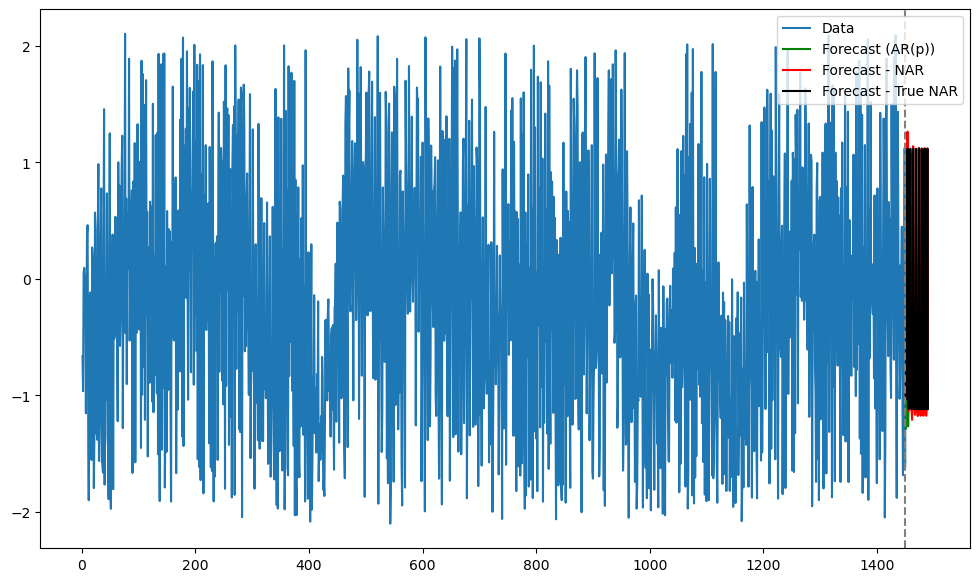

In [24]:
n_y = len(y_sim)
tme = range(1, n_y+1)
tme_future = range(n_y+1, n_y+k_future+1)
plt.figure(figsize = (12, 7))
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, fcast, label = 'Forecast (AR(p))', color = 'green')
plt.plot(tme_future, predictions, label = 'Forecast - NAR', color = 'red')
plt.plot(tme_future, actual_predictions, label = 'Forecast - True NAR', color = 'black')
plt.axvline(x=n_y, color='gray', linestyle='--')
plt.legend()
plt.show()

For better visualization, let us only plot the predictions obtained by the three models. 

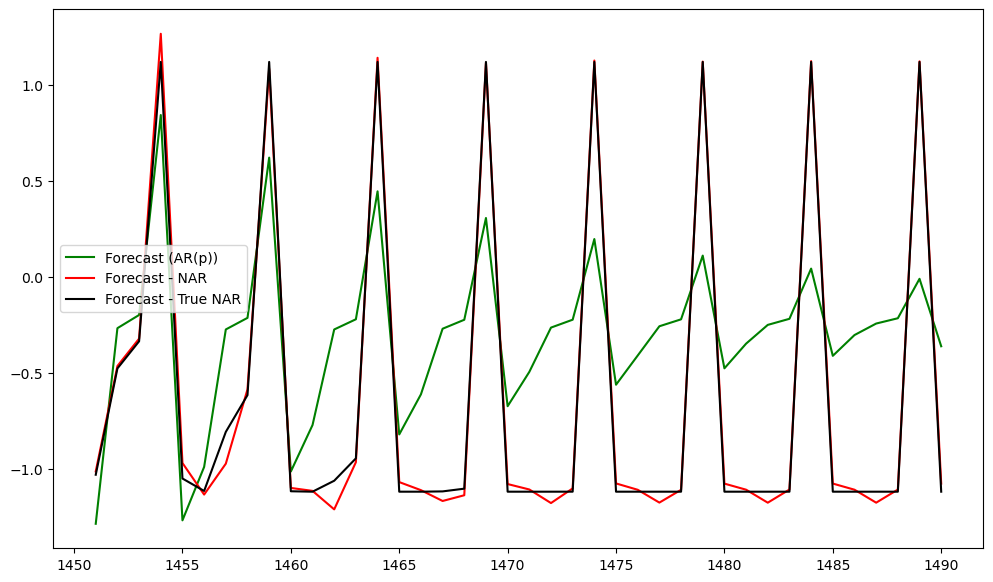

In [25]:
n_y = len(y_sim)
tme = range(1, n_y+1)
tme_future = range(n_y+1, n_y+k_future+1)
plt.figure(figsize = (12, 7))
plt.plot(tme_future, fcast, label = 'Forecast (AR(p))', color = 'green')
plt.plot(tme_future, predictions, label = 'Forecast - NAR', color = 'red')
plt.plot(tme_future, actual_predictions, label = 'Forecast - True NAR', color = 'black')
#plt.axvline(x=n_y, color='gray', linestyle='--')
plt.legend()
plt.show()

The closeness of predictions by the NAR($p$) model and AR($p$) model compared with the predictions obtained from the true value of $g$ are computed by the MSEs below. 

In [26]:
mse_ar = np.mean( (actual_predictions - fcast) ** 2) 
mse_NAR = np.mean( (actual_predictions - predictions) ** 2) 
print(mse_ar, mse_NAR, mse_ar/mse_NAR)

0.49578311371259687 0.0027808830340550596 178.28262017538012


Below we plot the data $(y_{t-5}, y_t)$ along with the actual function $g$, and the fitted values by the NAR($p$) model. 

torch.Size([1445])
torch.Size([1445])


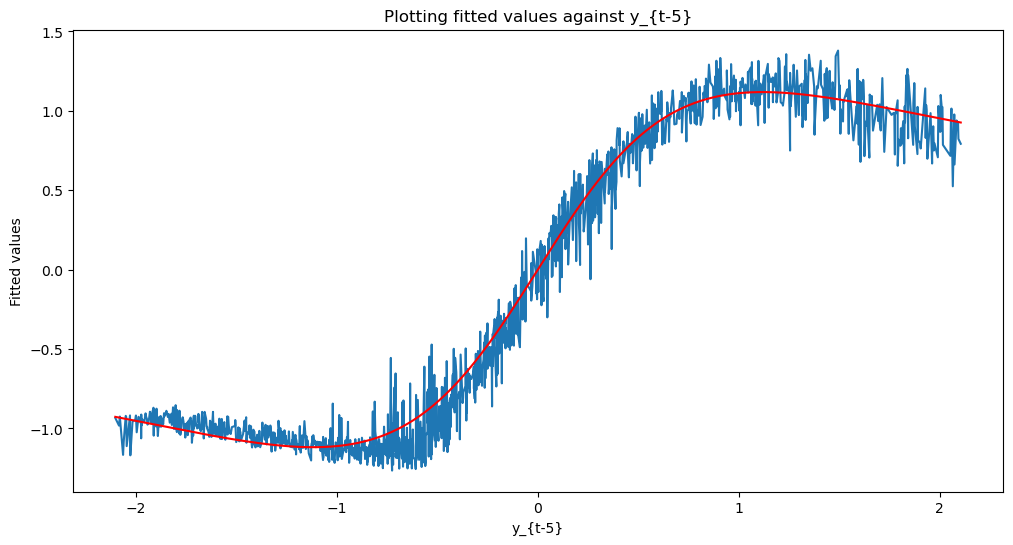

In [27]:
nar_fits = nar_model(x_data)

print(x_data[:,0].shape)
print(nar_fits.shape)

# Sort x_data[:,0] and corresponding nar_fits
sorted_indices = torch.argsort(x_data[:,0])
x_sorted = x_data[:,0][sorted_indices]
nar_fits_sorted = nar_fits[sorted_indices]


def g(x):
    return 2 * x / (1 + 0.8 * x**2)

true_g_vals = g(x_sorted.detach().numpy())

plt.figure(figsize=(12, 6))
plt.plot(x_sorted.detach().numpy(), nar_fits_sorted.detach().numpy(), label = 'Fitted values') 
plt.plot(x_sorted.detach().numpy(), true_g_vals, color = 'red', label = 'Actual g values')  
plt.title('Plotting fitted values against y_{t-5}')
plt.xlabel('y_{t-5}')
plt.ylabel('Fitted values')
plt.show()


## Example Three

Now we repeat the exercise but we now change $y_{t-5}$ to $y_{t-20}$. We also fit NAR($p$) and AR($p$) models with $p = 20$. Now NAR($p$) becomes a model with many parameters so there will be the issue of overfitting. 

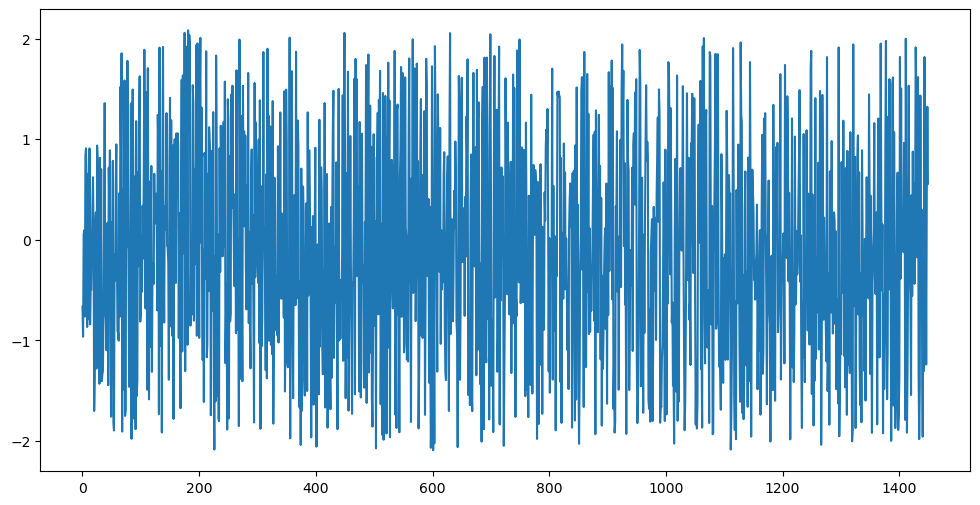

In [28]:
n = 1450
rng = np.random.default_rng(seed = 40)
eps = rng.uniform(low = -1.0, high = 1.0, size = n) 

truelag = 20
y_sim = np.full(n, 0, dtype = float) 
y_sim[:(truelag - 1)] = rng.uniform(low = -1, high = 1, size = truelag - 1)
for i in range(truelag, n):
    y_sim[i] = ((2*y_sim[i-truelag])/(1 + 0.8 * (y_sim[i-truelag] ** 2))) + eps[i]

plt.figure(figsize = (12, 6))
plt.plot(y_sim)
plt.show()

In [29]:
class SingleHiddenLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.W = nn.Linear(input_dim, hidden_dim)
        self.beta = nn.Linear(hidden_dim, 1)
    def forward(self, x): 
        s = self.W(x) 
        #r = torch.sigmoid(s)
        r = torch.relu(s)
        #r = torch.tanh(s)
        mu = self.beta(r)
        return mu.squeeze()

In [30]:
torch.manual_seed(3)

#Create x's and y's from the data (x is simply the lagged values). Also conversion to tensors. 
p = truelag
y = torch.tensor(y_sim, dtype = torch.float32)
n = len(y)
x_list = []
y_list = []
for t in range(p, n):
    x_list.append(y[t-p : t]) #(y_{t-1}, \dots, y_{t-p})
    y_list.append(y[t]) #y_t
x_data = torch.stack(x_list) #shape: (n-p, p)
y_data = torch.stack(y_list) #shape: (n-p,)

In [31]:
k = 6
nar_model = SingleHiddenLayerNN(input_dim=p, hidden_dim=k)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(nar_model.parameters(), lr = 0.01)

num_epochs = 10000
for epoch in range(num_epochs): 
    optimizer.zero_grad()
    mu_pred = nar_model(x_data)
    loss = loss_fn(mu_pred, y_data)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item(): .6f}")

Epoch 0, Loss:  1.454649
Epoch 200, Loss:  0.379441
Epoch 400, Loss:  0.373239
Epoch 600, Loss:  0.368197
Epoch 800, Loss:  0.367407
Epoch 1000, Loss:  0.367285
Epoch 1200, Loss:  0.367280
Epoch 1400, Loss:  0.367292
Epoch 1600, Loss:  0.367298
Epoch 1800, Loss:  0.367281
Epoch 2000, Loss:  0.367306
Epoch 2200, Loss:  0.367287
Epoch 2400, Loss:  0.367290
Epoch 2600, Loss:  0.367310
Epoch 2800, Loss:  0.367283
Epoch 3000, Loss:  0.367293
Epoch 3200, Loss:  0.367269
Epoch 3400, Loss:  0.367162
Epoch 3600, Loss:  0.367093
Epoch 3800, Loss:  0.364829
Epoch 4000, Loss:  0.364723
Epoch 4200, Loss:  0.364730
Epoch 4400, Loss:  0.364724
Epoch 4600, Loss:  0.364736
Epoch 4800, Loss:  0.364697
Epoch 5000, Loss:  0.364703
Epoch 5200, Loss:  0.364687
Epoch 5400, Loss:  0.364697
Epoch 5600, Loss:  0.364705
Epoch 5800, Loss:  0.364676
Epoch 6000, Loss:  0.364709
Epoch 6200, Loss:  0.364662
Epoch 6400, Loss:  0.364705
Epoch 6600, Loss:  0.364678
Epoch 6800, Loss:  0.364711
Epoch 7000, Loss:  0.364670

In [32]:
#Predictions
nar_model.eval()
predictions = []
k_future = 40
current_input = y[-p:]
for i in range(k_future):
    with torch.no_grad():
        mu = nar_model(current_input.unsqueeze(0))
    predictions.append(mu.item())
    current_input = torch.cat([current_input[1:], mu.unsqueeze(0)])
predictions = np.array(predictions)


In [33]:
current_input = y[-p:]
print(y)
print(current_input)
print(current_input[0])
print(current_input[0].detach().numpy())

tensor([-0.6649, -0.9638,  0.0533,  ...,  0.4710,  1.3228,  0.5566])
tensor([-0.1745,  1.3297,  1.6169, -1.3475, -1.9818, -1.4642,  1.4335, -0.4679,
         0.3011, -0.9683, -1.9576, -0.2013, -1.3051,  1.8167, -0.1115,  0.2793,
        -1.2411,  0.4710,  1.3228,  0.5566])
tensor(-0.1745)
-0.17447984


In [34]:
#Actual predictions using the true function: 
actual_predictions = []
current_input = y[-p:]
for i in range(k_future):
    lastval = current_input[0]
    next_val = ((2*lastval)/(1 + 0.8 * (lastval ** 2)))
    actual_predictions.append(next_val)
    current_input = np.concatenate([current_input[1:], np.array([next_val])])
actual_predictions = np.array(actual_predictions)


In [35]:
ar = AutoReg(y_sim, lags = p).fit() 
n_y = len(y_sim)
tme = range(1, n_y+1)
tme_future = range(n_y+1, n_y+k_future+1)
fcast = ar.get_prediction(start = n_y, end = n_y+k_future-1).predicted_mean

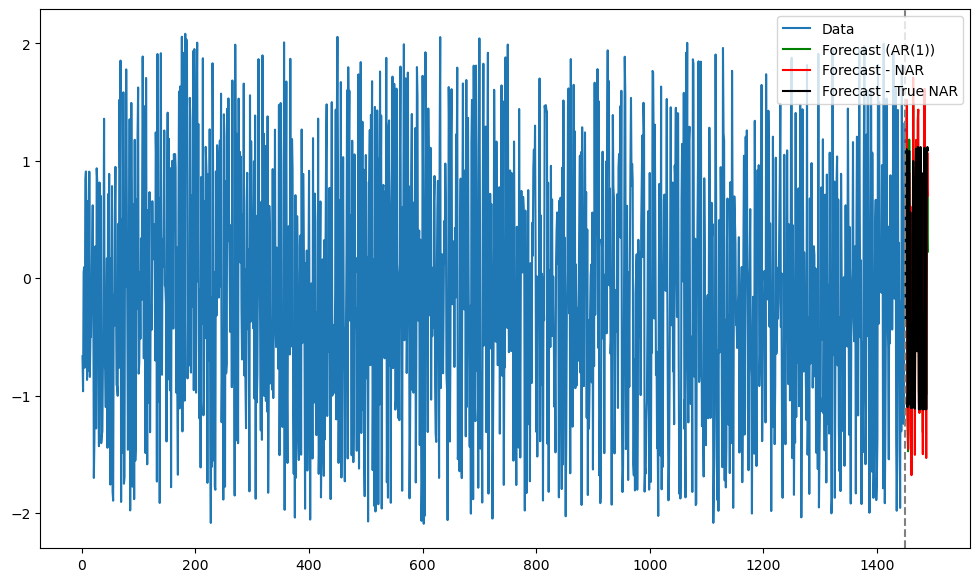

In [36]:
n_y = len(y_sim)
tme = range(1, n_y+1)
tme_future = range(n_y+1, n_y+k_future+1)
plt.figure(figsize = (12, 7))
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, fcast, label = 'Forecast (AR(1))', color = 'green')
plt.plot(tme_future, predictions, label = 'Forecast - NAR', color = 'red')
plt.plot(tme_future, actual_predictions, label = 'Forecast - True NAR', color = 'black')
plt.axvline(x=n_y, color='gray', linestyle='--')
plt.legend()
plt.show()

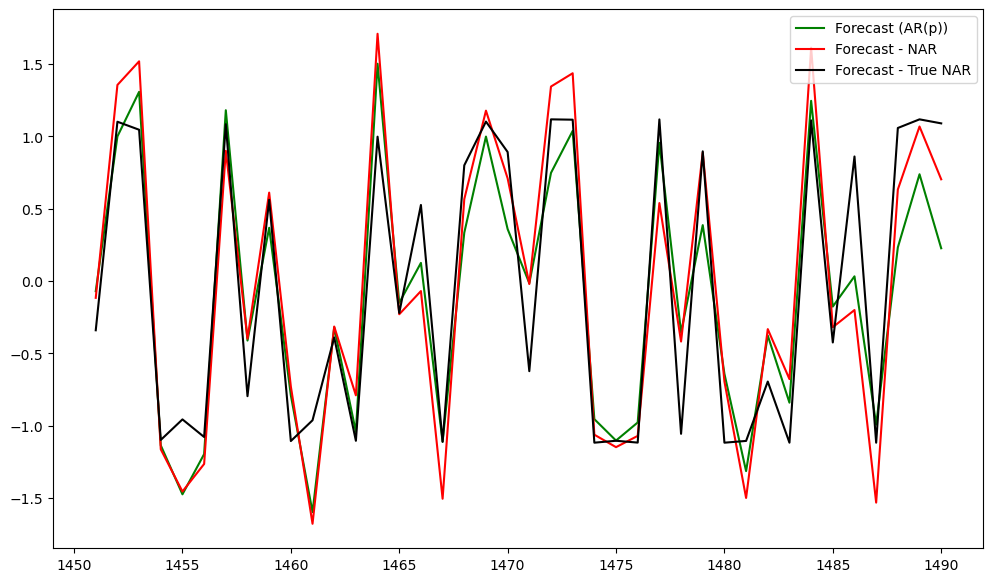

In [37]:
n_y = len(y_sim)
tme = range(1, n_y+1)
tme_future = range(n_y+1, n_y+k_future+1)
plt.figure(figsize = (12, 7))
plt.plot(tme_future, fcast, label = 'Forecast (AR(p))', color = 'green')
plt.plot(tme_future, predictions, label = 'Forecast - NAR', color = 'red')
plt.plot(tme_future, actual_predictions, label = 'Forecast - True NAR', color = 'black')
#plt.axvline(x=n_y, color='gray', linestyle='--')
plt.legend()
plt.show()

The predictions by NAR($p$) model are not as close to the true predictions (i.e., obtained using the true function $g$) as in the previous case when $p$ is small. In fact now, the predictions for the linear AR($p$) model seem closer to the true predictions. This is a result of overfitting. 

In [39]:
mse_ar = np.mean( (actual_predictions - fcast) ** 2) 
mse_NAR = np.mean( (actual_predictions - predictions) ** 2) 
print(mse_ar, mse_NAR, mse_ar/mse_NAR)

0.15533280348971384 0.1627774080292371 0.9542651241984017


torch.Size([1430])
torch.Size([1430])


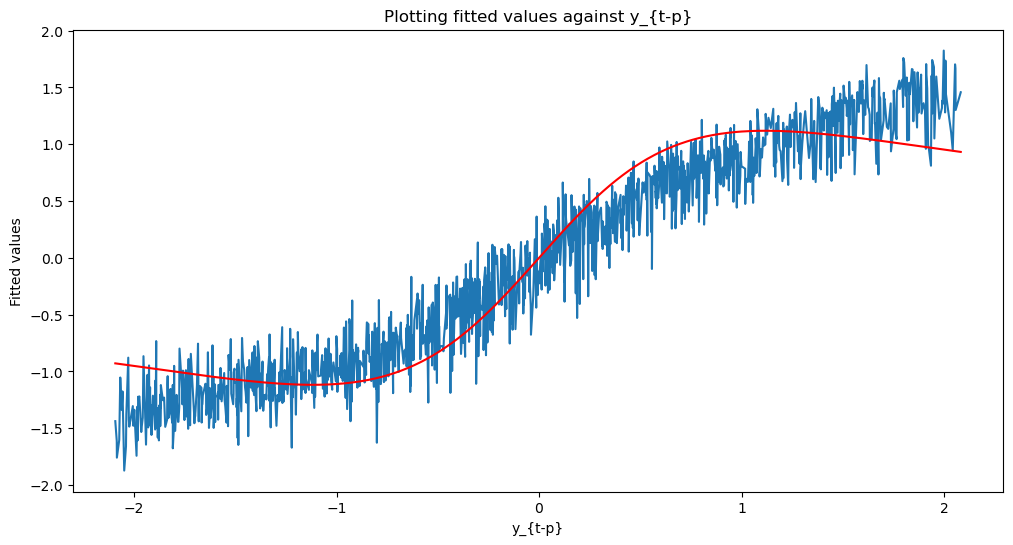

In [40]:
nar_fits = nar_model(x_data)

print(x_data[:,0].shape)
print(nar_fits.shape)

# Sort x_data[:,0] and corresponding nar_fits
sorted_indices = torch.argsort(x_data[:,0])
x_sorted = x_data[:,0][sorted_indices]
nar_fits_sorted = nar_fits[sorted_indices]


def g(x):
    return 2 * x / (1 + 0.8 * x**2)

true_g_vals = g(x_sorted.detach().numpy())

plt.figure(figsize=(12, 6))
plt.plot(x_sorted.detach().numpy(), nar_fits_sorted.detach().numpy(), label = 'Fitted values') 
plt.plot(x_sorted.detach().numpy(), true_g_vals, color = 'red', label = 'Actual g values')  
plt.title('Plotting fitted values against y_{t-p}')
plt.xlabel('y_{t-p}')
plt.ylabel('Fitted values')
plt.show()
